In [1]:
import torch, shap, glob
import numpy as np, pandas as pd, torchvision.transforms as transforms
import random

from feedback import *
from tqdm.notebook import tqdm
from torchvision.models import alexnet
from torch.nn import Module
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image

np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

In [2]:
save_weight_path ='./models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.30[NATCG]/'
# save_weight_path = './models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/'

weights_name = "weights_Multiclass_Covid19(Non-kmer3)[NACGT].2022.03.30.pt"
# weights_name = "weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt"

path2weights = os.path.join(save_weight_path,weights_name)

In [3]:
# npy_path = './np_image_totalunit/multiclass_totalunit/'
npy_path = './np_image_totalunit/multiclass_nactg/'

In [4]:
npy_data_list = [os.path.join(npy_path,'image_npy',i ) for i in sorted(os.listdir(os.path.join(npy_path,'image_npy')))]
label_ = np.load(os.path.join(npy_path,'label.npy'))

In [5]:
nas_path = "./dataset_1401/"
lineage_label = pd.read_csv('./dataset_1401/1404_lineage_report and metadata 20220316.csv')[['scorpio_call_y','diff']]
lineage_label = np.array(lineage_label.fillna("None"))
label_s = []
name_ = []
new_lineage_label = []
for idx, rna in enumerate(SeqIO.parse('./dataset_1401/1404.sequences.aln.fasta',"fasta")):
    # print(lineage_label[idx][0].split(' ')[0])
    label_s.append(lineage_label[idx][0].split(' ')[0])
    name_.append(lineage_label[idx][0])
    new_lineage_label.append(str(rna.seq).replace('-','N'))

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npy_data_list, label_,stratify = label_, test_size=0.25, random_state=42)

print(len(X_train), len(y_train)) 

print(len(X_test), len(y_test))

1053 1053
351 351


In [7]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class TransferDataset(Dataset):
    def __init__(self, s_path, labels, transform):
        self.transform = transform
        self.s_path = s_path
        self.labels = labels
        
    def __len__(self):
        return len(self.s_path)

    def __getitem__(self, idx):
        singel_image_ = np.load(self.s_path[idx]).astype(np.float32)
        seed = np.random.randint(1e9)       
        random.seed(seed)
        np.random.seed(seed)
        singel_image_ = self.transform(singel_image_)
        label = int(self.labels[idx])
        # print(label)

        return singel_image_, label

In [8]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean, std),
            ])     

train_ds = TransferDataset(s_path= X_train, labels= y_train, transform= transformer)
test_ds = TransferDataset(s_path= X_test, labels= y_test, transform= transformer)
print(len(train_ds), len(test_ds))

1053 351


In [9]:
imgs, label = train_ds[10]
batch_size = 32
train_dl = DataLoader(train_ds, batch_size= batch_size, 
                        shuffle=True)
test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                        shuffle=False)  

In [10]:
# eval
models = alexnet(pretrained=False, num_classes=max(label_)+1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(path2weights, map_location=torch.device('cpu'))
# checkpoint = torch.load('./models/weights_Multiclass_Covid19(Non-kmer3)_IndexRemark.2022.03.24[NACGTRYKMSWBDHV]/weights_Multiclass_Covid19(Non-kmer3)[NACGTRYKMSWBDHV].2022.03.24.pt', map_location=torch.device('cpu'))
models.load_state_dict(checkpoint['model_state_dict'])
models.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
test_dl = DataLoader(test_ds, batch_size= 351, 
                        shuffle=False)  
models.eval()
with torch.no_grad():
    for xb, yb in tqdm(test_dl):
        xb=xb.to(device)
        yb=yb.to(device)
    predict_result = np.argmax(models(xb), axis=1).numpy()
    ground_truth = yb.numpy()

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(ground_truth, predict_result)

0.9401709401709402

In [13]:
train_dl = DataLoader(train_ds, batch_size= 1053, 
                        shuffle=False)
test_dl = DataLoader(test_ds, batch_size= 351, 
                        shuffle=False)  

In [14]:
# {'Alpha': 0, 'B.1.1.318-like': 1, 'Beta': 2, 'Delta': 3, 'Eta': 4, 'Gamma': 5, 'Iota': 6, 'Lambda': 7, 'Mu': 8, 'None': 9}
models.eval()
with torch.no_grad():
    batch = next(iter(test_dl))
    images, label = batch
    pred = models(images)
    Y_val = label

In [15]:
# since shuffle=True, this is a random sample of test data
test_batch = next(iter(test_dl))
t_images, t_label = test_batch

batch_background = next(iter(train_dl))
b_images, b_label = batch_background

print(b_images.shape, b_label.shape)
print(t_images.shape, t_label.shape)

torch.Size([1053, 3, 100, 100]) torch.Size([1053])
torch.Size([351, 3, 100, 100]) torch.Size([351])


In [16]:
e = shap.DeepExplainer(models, b_images)

In [17]:
seq_list = [[idx, image, label] for idx, (image, label) in enumerate(zip(X_test, y_test))]
seq_index_list = [int(i[1][-8:-4]) for i in seq_list]
print(len(t_images), len(seq_index_list))

351 351


In [18]:
from tqdm.notebook import tqdm
# # save npy
save_path = './shap_npy/multiclass_nactg_2022.03.30'
# for idx, (img_, seq_n) in enumerate(tqdm(zip(t_images[150::],seq_list[150::]))):
#     sav_name = seq_n[1][-8:-4]
#     sv = e.shap_values(torch.unsqueeze(img_, axis=0))
#     np.save(f"{save_path}/{sav_name}.npy", sv)
#     # break


In [19]:
label_class = ['Alpha', 'B.1.1.318-like', 'Beta', 'Delta', 'Eta', 'Gamma', 'Iota', 'Lambda', 'Mu', 'None']
location_map =np.load('./deepinsight_location_npy/coords_[NACGT]-multiclass=1404.npy')
square_map = np.load('./deepinsight_location_npy/feature_density_matrix_[NACGT]-multiclass=1404.npy')
total_sv_image_class_dict = {'Alpha': [], 'B.1.1.318-like':[], 'Beta':[], 'Delta':[], 'Eta':[], 'Gamma':[], 'Iota':[], 'Lambda':[], 'Mu':[], 'None':[]}
for idx1, (exp_image, sv_npy) in enumerate(tqdm(zip(t_images, seq_list))):
    if label_class[Y_val[idx1]]==label_class[np.argmax(pred.numpy(), axis=1)[idx1]]: # if ground truth == predict result
        sav_name = sv_npy[1][-8:-4]
        # print(sav_name)
        # print(os.path.join(save_path,f"{sav_name}.npy"))
        load_ = np.load(os.path.join(save_path,f"{sav_name}.npy"))
        # print(load_.shape)
        shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in load_]
        # test_numpy = np.swapaxes(np.swapaxes(torch.unsqueeze(exp_image, axis=0).numpy(), 1, -1), 1, 2)
        # pred_round = np.round(torch.softmax(pred[idx1], axis=0).numpy(), 3)
        
        # print(np.argmax(pred.numpy(), axis=1)[idx])
        # print("Real Label: {}".format(label_class[Y_val[idx]]),   "Pred Label: {}".format(label_class[np.argmax(pred.numpy(), axis=1)[idx]]))
        
        # Extract Seq Image feature
        image = np.squeeze(shap_numpy[np.argmax(pred.numpy(), axis=1)[idx1]])
        image_sum = image[:,:,0]
        # print(test_numpy.shape)
        # pred_class = [str(i[0])+'\n'+str(i[1]) for i in zip(label_class, pred_round)]
        # shap.image_plot(shap_numpy, -test_numpy[:,:,:,1], pred_class,show=True)  #plot shap value axe
        # break
        single_seq = new_lineage_label[int(sav_name)] #get original sequence
        important_location = {}
        for  x_id, x_value in enumerate(image_sum):
            for y_id, y_value in enumerate(x_value):
                if y_value!=0:
                    important_location[x_id,y_id] = round(y_value,10)
                    # print(f"[{x_id},{y_id}] = {round(y_value,4)}")
        Sample_filter_important_value_list = []
        for idx2, (seq_rna, location_xy) in enumerate(zip(single_seq, location_map)):
            if (location_xy[0], location_xy[1]) in (list(important_location.keys())):
                # print("Seq Index: ",idx,"Acid: ", seq_rna, "Mat location [X, Y]: ",location_xy ,"Value: ", important_location[location_xy[0], location_xy[1]])
                Sample_filter_important_value_list.append([idx2, seq_rna, location_xy, important_location[location_xy[0], location_xy[1]]])
        Sample_filter_important_value_list.sort(key = lambda s: s[3], reverse = True)
        total_sv_image_class_dict[label_class[np.argmax(pred.numpy(), axis=1)[idx1]]].append(Sample_filter_important_value_list)

0it [00:00, ?it/s]

In [20]:
total_sv_image_class_dict['Gamma'][0][0]

[7, 'N', array([50, 70]), 14.1307535172]

In [21]:
class_dict = {}
for classes in total_sv_image_class_dict:
    class_dict[classes] = {}
    if len(total_sv_image_class_dict[classes])!=0:
        index_location_dict = {}
        for single_seq in total_sv_image_class_dict[classes]:
            for rna_position in single_seq:
                if (rna_position[0], rna_position[1]) not  in index_location_dict.keys():
                    index_location_dict[rna_position[0], rna_position[1]] = rna_position[-1]
                else:
                    index_location_dict[rna_position[0], rna_position[1]] += rna_position[-1]
        print(len(index_location_dict))
        class_dict[classes] = index_location_dict
        # #     break
        # # break
    

33838
22941
18482
21215


In [22]:
for i in class_dict.keys():
    class_dict[i] = {k: v for k, v in sorted(class_dict[i].items(), key=lambda item: item[1], reverse=True)}

class_dict_minus_sign ={}
for i in class_dict.keys():
    class_dict_minus_sign[i] = {k: v for k, v in sorted(class_dict[i].items(), key=lambda item: item[1], reverse=False)}

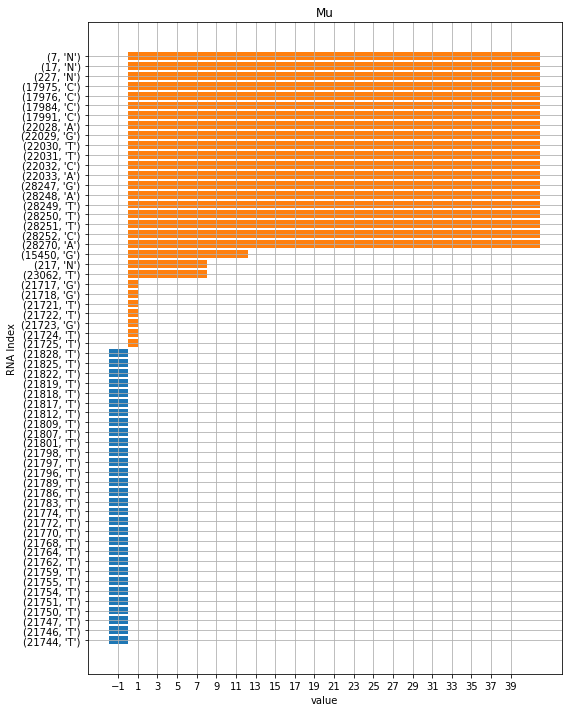

In [85]:
title_label = 'Mu'
count = 0
label_plus = []
values_plus = []

label_minus_sign = []
values_minus_sign = []
for i in class_dict[title_label]:
        if count!=30:
                label_plus.append(str(i))
                values_plus.append(class_dict[title_label][i])
                count+=1
        else:
                break
for i in class_dict_minus_sign[title_label]:
        if count!=60:
                label_minus_sign.append(str(i))
                values_minus_sign.append(class_dict_minus_sign[title_label][i])
                count+=1
        else:
                break
plt.figure(figsize=(8, 10))
plt.barh(label_minus_sign,
        [i/1 for i in values_minus_sign])
plt.barh(label_plus[::-1],
        [i/1 for i in values_plus[::-1]])
x_ticks=np.arange(int(min(values_minus_sign))//1,int(max(values_plus))//1,2) 
plt.xticks(x_ticks)     
# plt.xticks(rotation='vertical')
plt.xlabel("value")

plt.ylabel("RNA Index")
plt.title(title_label)
plt.tight_layout()

plt.grid()
plt.show()

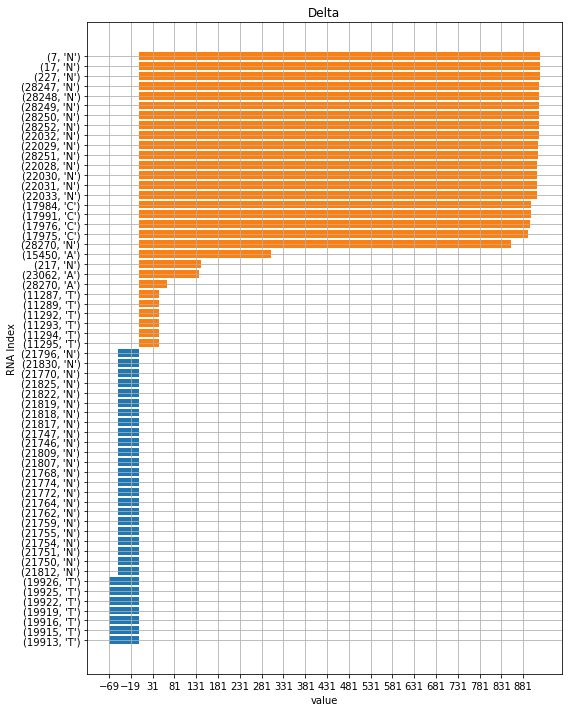

In [87]:
title_label = 'Delta'
count = 0
label_plus = []
values_plus = []

label_minus_sign = []
values_minus_sign = []
for i in class_dict[title_label]:
        if count!=30:
                label_plus.append(str(i))
                values_plus.append(class_dict[title_label][i])
                count+=1
        else:
                break
for i in class_dict_minus_sign[title_label]:
        if count!=60:
                label_minus_sign.append(str(i))
                values_minus_sign.append(class_dict_minus_sign[title_label][i])
                count+=1
        else:
                break
plt.figure(figsize=(8, 10))
plt.barh(label_minus_sign,
        [i/1 for i in values_minus_sign])
plt.barh(label_plus[::-1],
        [i/1 for i in values_plus[::-1]])
x_ticks=np.arange(int(min(values_minus_sign))//1,int(max(values_plus))//1,50) 
plt.xticks(x_ticks)     
# plt.xticks(rotation='vertical')
plt.xlabel("value")

plt.ylabel("RNA Index")
plt.title(title_label)
plt.tight_layout()

plt.grid()
plt.show()

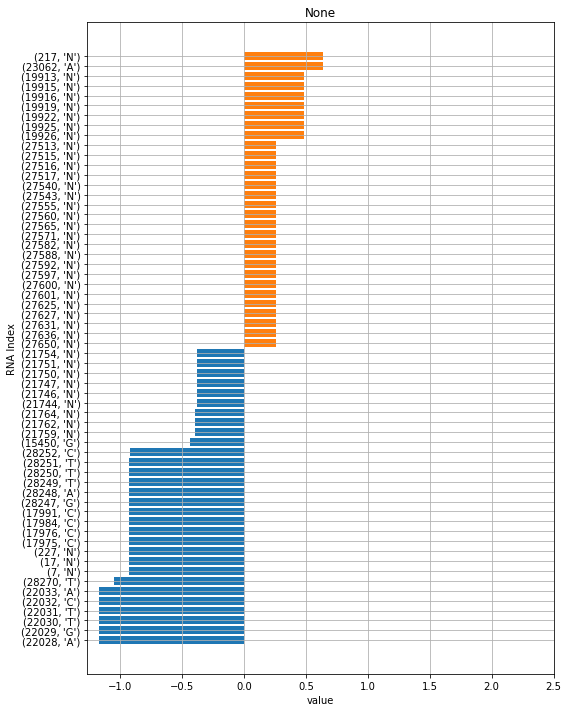

In [95]:
title_label = 'None'
count = 0
label_plus = []
values_plus = []

label_minus_sign = []
values_minus_sign = []
for i in class_dict[title_label]:
        if count!=30:
                label_plus.append(str(i))
                values_plus.append(class_dict[title_label][i])
                count+=1
        else:
                break
for i in class_dict_minus_sign[title_label]:
        if count!=60:
                label_minus_sign.append(str(i))
                values_minus_sign.append(class_dict_minus_sign[title_label][i])
                count+=1
        else:
                break
plt.figure(figsize=(8, 10))
plt.barh(label_minus_sign,
        [i/1 for i in values_minus_sign])
plt.barh(label_plus[::-1],
        [i/1 for i in values_plus[::-1]])
x_ticks=np.arange(int(min(values_minus_sign))//1,int(max(values_plus))//1+3,0.5) 
plt.xticks(x_ticks)     
# plt.xticks(rotation='vertical')
plt.xlabel("value")

plt.ylabel("RNA Index")
plt.title(title_label)
plt.tight_layout()

plt.grid()
plt.show()

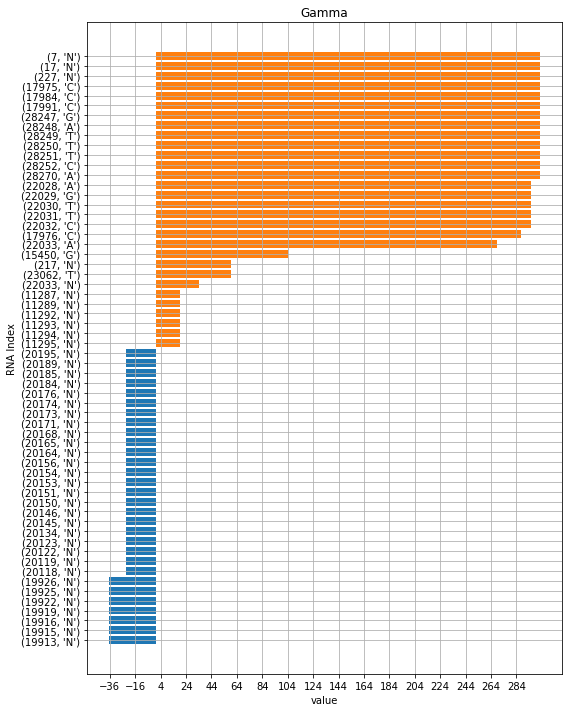

In [97]:
title_label = 'Gamma'
count = 0
label_plus = []
values_plus = []

label_minus_sign = []
values_minus_sign = []
for i in class_dict[title_label]:
        if count!=30:
                label_plus.append(str(i))
                values_plus.append(class_dict[title_label][i])
                count+=1
        else:
                break
for i in class_dict_minus_sign[title_label]:
        if count!=60:
                label_minus_sign.append(str(i))
                values_minus_sign.append(class_dict_minus_sign[title_label][i])
                count+=1
        else:
                break
plt.figure(figsize=(8, 10))
plt.barh(label_minus_sign,
        [i/1 for i in values_minus_sign])
plt.barh(label_plus[::-1],
        [i/1 for i in values_plus[::-1]])
x_ticks=np.arange(int(min(values_minus_sign))//1,int(max(values_plus))//1,20) 
plt.xticks(x_ticks)     
# plt.xticks(rotation='vertical')
plt.xlabel("value")

plt.ylabel("RNA Index")
plt.title(title_label)
plt.tight_layout()

plt.grid()
plt.show()